# Land Classifier Pipeline

This notebook runs the pipeline in ordered stages:
1. Data preparation
2. Rule-based model run
3. Rule-based output preview
4. Baseline + v2 + v3 model runs (train, infer, preview)

Notes:
- You may be prompted to authenticate Earth Engine during the first GEE call.
- Training and inference can take a long time. Run cells sequentially.
- Dependencies install from `requirements-colab.txt`.
- GEE script used for t-1, t, t+1 NDVI/EVI/BSI inspection: https://noble-truck-479712-a1.projects.earthengine.app/view/years-khajura


In [ ]:
from pathlib import Path
import os
import subprocess
import sys

REPO_URL = "https://github.com/KU-GEOI-525-2023/fallow-land-detection-khajura-bilstm.git"
REPO_DIR = Path.cwd() / "fallow-land-detection-khajura-bilstm"

if not REPO_DIR.exists():
    subprocess.run(["git", "clone", REPO_URL, str(REPO_DIR)], check=True)
else:
    print(f"Repo already exists at {REPO_DIR}")

os.chdir(REPO_DIR)
print(f"Working directory: {Path.cwd()}")

subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r", "requirements-colab.txt"], check=True)
src_path = Path.cwd() / "src"
os.environ["PYTHONPATH"] = str(src_path)
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project=os.environ["GEE_PROJECT_ID"])

## 1. Data preparation


In [ ]:
import os

os.environ.setdefault("GEE_PROJECT_ID", "noble-truck-479712-a1")
print("GEE_PROJECT_ID set to", os.environ["GEE_PROJECT_ID"])


In [ ]:
from pathlib import Path
import subprocess
import sys

from omegaconf import OmegaConf
from IPython.display import Image, display

DATA_CONFIG = "configs/data/dataset_v2.yaml"
RULE_BASED_CONFIG = "configs/baselines/rule_based.yaml"
TRAIN_BASELINE_CONFIG = "configs/train/baseline.yaml"
TRAIN_V2_CONFIG = "configs/train/v2_optimized.yaml"
TRAIN_V3_CONFIG = "configs/train/v3_stable.yaml"
INFER_BASELINE_CONFIG = "configs/inference/baseline.yaml"
INFER_V2_CONFIG = "configs/inference/v2.yaml"
INFER_V3_CONFIG = "configs/inference/v3.yaml"

TRAIN_BASELINE_NAME = Path(TRAIN_BASELINE_CONFIG).stem
TRAIN_V2_NAME = Path(TRAIN_V2_CONFIG).stem
TRAIN_V3_NAME = Path(TRAIN_V3_CONFIG).stem

def run_cmd(args):
    print("+", " ".join(args))
    subprocess.run(args, check=True)

def run_rule_based():
    run_cmd([sys.executable, "-m", "land_classifier.baselines.rule_based_land_classifier", "--config", RULE_BASED_CONFIG])
    run_cmd([sys.executable, "-m", "land_classifier.evaluation.evaluate_rule_based", "--config", RULE_BASED_CONFIG])

def run_train(train_name):
    run_cmd([sys.executable, "-m", "land_classifier.training.train", f"train={train_name}"])

def run_infer(config_path):
    run_cmd([sys.executable, "-m", "land_classifier.inference.inference", "--config", config_path])

def run_plot(config_path):
    run_cmd([sys.executable, "-m", "land_classifier.visualization.plot_classification_map", "--config", config_path])

def show_classification_png(config_path: str) -> None:
    cfg = OmegaConf.load(config_path)
    plot_cfg = cfg.get("classification_plot")
    if not plot_cfg:
        print(f"Missing classification_plot in {config_path}")
        return
    output_path = Path(plot_cfg.get("output_path", ""))
    if output_path.exists():
        display(Image(filename=str(output_path)))
    else:
        print(f"Missing: {output_path}")


In [ ]:
run_cmd([sys.executable, "-m", "land_classifier.data.scripts.extract_training_data_v2", "--config", DATA_CONFIG])


## 2. Rule-based model run


In [27]:
run_rule_based()


Progress: 30/210 tiles (14.3%), 309.3s
Progress: 40/210 tiles (19.0%), 476.5s
Progress: 50/210 tiles (23.8%), 590.4s
Progress: 60/210 tiles (28.6%), 687.6s
Progress: 70/210 tiles (33.3%), 806.5s
Progress: 80/210 tiles (38.1%), 928.9s
Progress: 90/210 tiles (42.9%), 1023.9s
Progress: 100/210 tiles (47.6%), 1126.5s
Progress: 110/210 tiles (52.4%), 1214.7s
Progress: 120/210 tiles (57.1%), 1338.6s
Progress: 130/210 tiles (61.9%), 1447.4s
Progress: 140/210 tiles (66.7%), 1617.4s
Progress: 150/210 tiles (71.4%), 1732.4s
Progress: 160/210 tiles (76.2%), 1829.3s
Progress: 170/210 tiles (81.0%), 1930.7s
Progress: 180/210 tiles (85.7%), 2033.4s
Progress: 190/210 tiles (90.5%), 2132.3s
Progress: 200/210 tiles (95.2%), 2224.0s
Progress: 210/210 tiles (100.0%), 2317.9s
Saved: /home/naxa/Projects/fallow-agro-land-deep-learning/models/exports/rule_based_land_status.tif
+ /home/naxa/.cache/pypoetry/virtualenvs/land-classifier-final-FOKqVZt_-py3.12/bin/python -m land_classifier.evaluation.evaluate_rule

## 3. Rule-based output preview


In [28]:
run_plot(RULE_BASED_CONFIG)


+ /home/naxa/.cache/pypoetry/virtualenvs/land-classifier-final-FOKqVZt_-py3.12/bin/python -m land_classifier.visualization.plot_classification_map --config configs/baselines/rule_based.yaml
Saved: /home/naxa/Projects/fallow-agro-land-deep-learning/outputs/landuse/figures/rule_based_classification.png


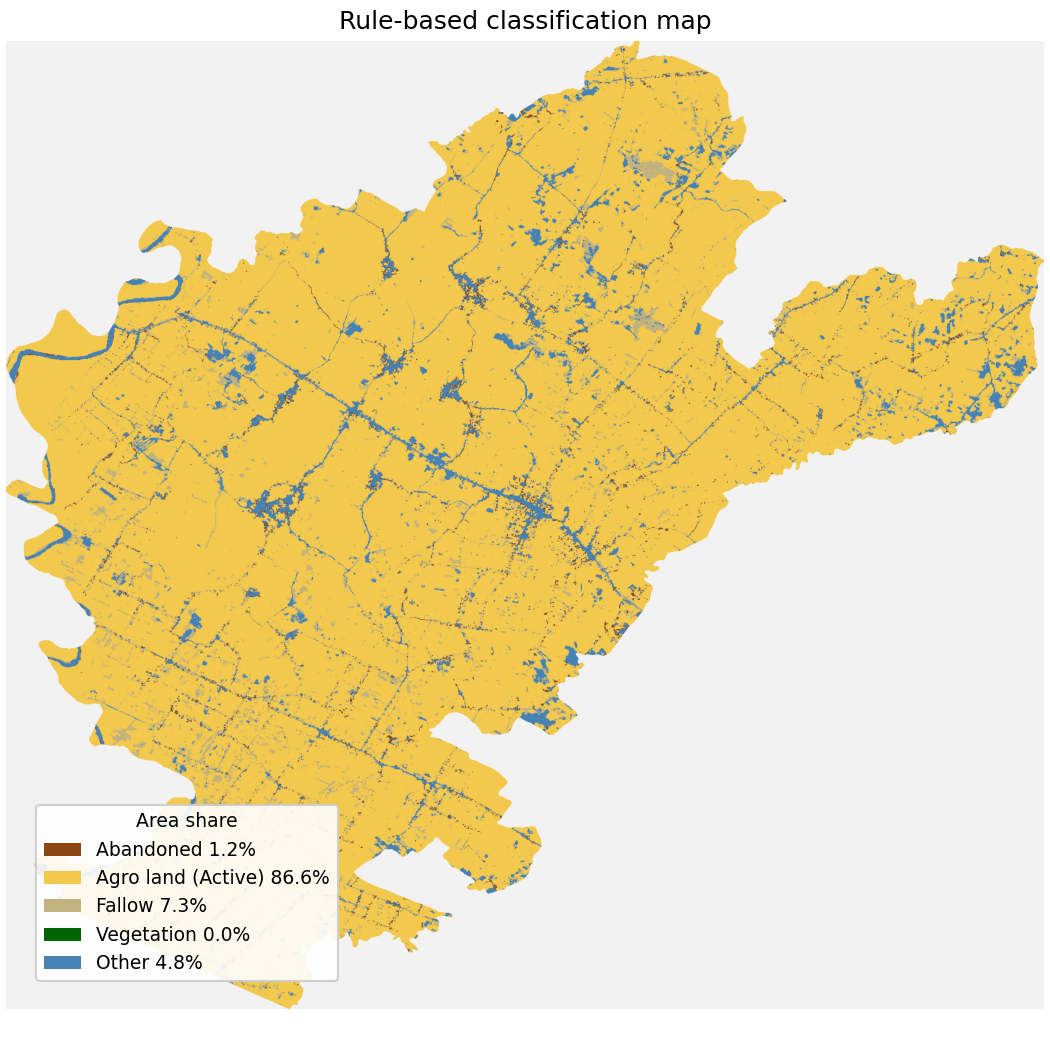

In [29]:
show_classification_png(RULE_BASED_CONFIG)


## 4. Baseline + v2 + v3 model runs


In [30]:
run_train(TRAIN_BASELINE_NAME)


+ /home/naxa/.cache/pypoetry/virtualenvs/land-classifier-final-FOKqVZt_-py3.12/bin/python -m land_classifier.training.train train=baseline


<frozen runpy>:128: RuntimeWarning: 'land_classifier.training.train' found in sys.modules after import of package 'land_classifier.training', but prior to execution of 'land_classifier.training.train'; this may result in unpredictable behaviour


[2026-01-11 19:59:58,609][__main__][INFO] - Hydra directory: /home/naxa/Projects/fallow-agro-land-deep-learning
[2026-01-11 19:59:58,611][__main__][INFO] - Config:
data:
  data_dir: data/processed
  features_file: X_train.npy
  labels_file: y_train.npy
  batch_size: 32
  num_workers: 0
  pin_memory: true
  val_split: 0.2
  random_seed: 42
  use_weighted_sampler: true
  sampler_power: 0.7
  class_names:
  - Abandoned
  - Active
  - Fallow
  - Vegetation
  - Other
  split_by: auto
  normalize: true
  augment: true
  extract:
    project:
      id: ${oc.env:GEE_PROJECT_ID,"noble-truck-479712-a1"}
    mask_mode: scl
    dates:
      start_date: '2022-01-01'
      end_date: '2024-12-31'
    cloud_filters:
    - 60
    - 70
    - 80
    step_days: 20
    nodata: -9999.0
    paths:
      data_dir: data
      processed_dir: ${data_dir}
      output_file_x: ${data_dir}/${features_file}
      output_file_y: ${data_dir}/${labels_file}
      output_file_sources: ${data_dir}/sample_sources.npy
    

Epoch 002:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.6399]        

[2026-01-11 20:00:01,621][__main__][INFO] - Epoch 001/200 | Loss (T/V): 1.6697 / 1.6411 | Val F1: 0.1742 | Acc: 0.2462
[2026-01-11 20:00:01,626][__main__][INFO] - Best model saved (f1=0.1742)
[2026-01-11 20:00:01,733][__main__][INFO] - Epoch 002/200 | Loss (T/V): 1.6414 / 1.6460 | Val F1: 0.1081 | Acc: 0.2000


Epoch 004:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.5340]        

[2026-01-11 20:00:01,870][__main__][INFO] - Epoch 003/200 | Loss (T/V): 1.5992 / 1.6345 | Val F1: 0.1706 | Acc: 0.2308
[2026-01-11 20:00:01,979][__main__][INFO] - Epoch 004/200 | Loss (T/V): 1.5898 / 1.6144 | Val F1: 0.2013 | Acc: 0.2615
[2026-01-11 20:00:01,984][__main__][INFO] - Best model saved (f1=0.2013)


Epoch 006:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.5266]

[2026-01-11 20:00:02,086][__main__][INFO] - Epoch 005/200 | Loss (T/V): 1.5765 / 1.5708 | Val F1: 0.2778 | Acc: 0.3077
[2026-01-11 20:00:02,091][__main__][INFO] - Best model saved (f1=0.2778)
[2026-01-11 20:00:02,193][__main__][INFO] - Epoch 006/200 | Loss (T/V): 1.5475 / 1.5234 | Val F1: 0.3896 | Acc: 0.4154
[2026-01-11 20:00:02,197][__main__][INFO] - Best model saved (f1=0.3896)


Epoch 008:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.5757]

[2026-01-11 20:00:02,292][__main__][INFO] - Epoch 007/200 | Loss (T/V): 1.5343 / 1.4789 | Val F1: 0.4359 | Acc: 0.4615
[2026-01-11 20:00:02,295][__main__][INFO] - Best model saved (f1=0.4359)
[2026-01-11 20:00:02,355][__main__][INFO] - Epoch 008/200 | Loss (T/V): 1.5109 / 1.4398 | Val F1: 0.4108 | Acc: 0.4308
[2026-01-11 20:00:02,457][__main__][INFO] - Epoch 009/200 | Loss (T/V): 1.4899 / 1.3975 | Val F1: 0.4132 | Acc: 0.4308


Epoch 012:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.4367]

[2026-01-11 20:00:02,559][__main__][INFO] - Epoch 010/200 | Loss (T/V): 1.4568 / 1.3623 | Val F1: 0.4298 | Acc: 0.4462
[2026-01-11 20:00:02,661][__main__][INFO] - Epoch 011/200 | Loss (T/V): 1.4332 / 1.3300 | Val F1: 0.3607 | Acc: 0.4154


Epoch 014:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.5634]

[2026-01-11 20:00:02,763][__main__][INFO] - Epoch 012/200 | Loss (T/V): 1.4105 / 1.3036 | Val F1: 0.4102 | Acc: 0.4615
[2026-01-11 20:00:02,866][__main__][INFO] - Epoch 013/200 | Loss (T/V): 1.3882 / 1.2807 | Val F1: 0.4520 | Acc: 0.4769
[2026-01-11 20:00:02,870][__main__][INFO] - Best model saved (f1=0.4520)


Epoch 016:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.3838]

[2026-01-11 20:00:02,975][__main__][INFO] - Epoch 014/200 | Loss (T/V): 1.3780 / 1.2692 | Val F1: 0.4865 | Acc: 0.5077
[2026-01-11 20:00:02,980][__main__][INFO] - Best model saved (f1=0.4865)
[2026-01-11 20:00:03,082][__main__][INFO] - Epoch 015/200 | Loss (T/V): 1.3779 / 1.2631 | Val F1: 0.5252 | Acc: 0.5385
[2026-01-11 20:00:03,086][__main__][INFO] - Best model saved (f1=0.5252)


Epoch 018:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.3519]

[2026-01-11 20:00:03,190][__main__][INFO] - Epoch 016/200 | Loss (T/V): 1.3665 / 1.2579 | Val F1: 0.5220 | Acc: 0.5385
[2026-01-11 20:00:03,295][__main__][INFO] - Epoch 017/200 | Loss (T/V): 1.3358 / 1.2510 | Val F1: 0.5362 | Acc: 0.5538
[2026-01-11 20:00:03,299][__main__][INFO] - Best model saved (f1=0.5362)


Epoch 020:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.2943]

[2026-01-11 20:00:03,403][__main__][INFO] - Epoch 018/200 | Loss (T/V): 1.3300 / 1.2460 | Val F1: 0.5412 | Acc: 0.5538
[2026-01-11 20:00:03,407][__main__][INFO] - Best model saved (f1=0.5412)
[2026-01-11 20:00:03,509][__main__][INFO] - Epoch 019/200 | Loss (T/V): 1.3306 / 1.2434 | Val F1: 0.5417 | Acc: 0.5538
[2026-01-11 20:00:03,514][__main__][INFO] - Best model saved (f1=0.5417)


Epoch 022:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.3415]

[2026-01-11 20:00:03,618][__main__][INFO] - Epoch 020/200 | Loss (T/V): 1.3267 / 1.2420 | Val F1: 0.5454 | Acc: 0.5538
[2026-01-11 20:00:03,622][__main__][INFO] - Best model saved (f1=0.5454)
[2026-01-11 20:00:03,684][__main__][INFO] - Epoch 021/200 | Loss (T/V): 1.3181 / 1.2407 | Val F1: 0.5290 | Acc: 0.5385
[2026-01-11 20:00:03,784][__main__][INFO] - Epoch 022/200 | Loss (T/V): 1.3017 / 1.2426 | Val F1: 0.5227 | Acc: 0.5385


[2026-01-11 20:00:03,852][__main__][INFO] - Epoch 023/200 | Loss (T/V): 1.2983 / 1.2416 | Val F1: 0.5288 | Acc: 0.5385
[2026-01-11 20:00:03,875][__main__][INFO] - Epoch 024/200 | Loss (T/V): 1.3273 / 1.2358 | Val F1: 0.5347 | Acc: 0.5538
[2026-01-11 20:00:03,896][__main__][INFO] - Epoch 025/200 | Loss (T/V): 1.3274 / 1.2346 | Val F1: 0.5428 | Acc: 0.5538
[2026-01-11 20:00:03,917][__main__][INFO] - Epoch 026/200 | Loss (T/V): 1.2906 / 1.2349 | Val F1: 0.5601 | Acc: 0.5692
[2026-01-11 20:00:03,918][__main__][INFO] - Best model saved (f1=0.5601)
[2026-01-11 20:00:03,939][__main__][INFO] - Epoch 027/200 | Loss (T/V): 1.3045 / 1.2319 | Val F1: 0.5270 | Acc: 0.5385
[2026-01-11 20:00:03,959][__main__][INFO] - Epoch 028/200 | Loss (T/V): 1.2969 / 1.2277 | Val F1: 0.5489 | Acc: 0.5538
[2026-01-11 20:00:03,979][__main__][INFO] - Epoch 029/200 | Loss (T/V): 1.3085 / 1.2245 | Val F1: 0.5593 | Acc: 0.5692
[2026-01-11 20:00:04,000][__main__][INFO] - Epoch 030/200 | Loss (T/V): 1.2716 / 1.2199 | Val 

[2026-01-11 20:00:04,062][__main__][INFO] - Epoch 033/200 | Loss (T/V): 1.2600 / 1.2162 | Val F1: 0.5549 | Acc: 0.5692
[2026-01-11 20:00:04,082][__main__][INFO] - Epoch 034/200 | Loss (T/V): 1.2929 / 1.2209 | Val F1: 0.5407 | Acc: 0.5538
[2026-01-11 20:00:04,102][__main__][INFO] - Epoch 035/200 | Loss (T/V): 1.2544 / 1.2194 | Val F1: 0.5424 | Acc: 0.5538
[2026-01-11 20:00:04,122][__main__][INFO] - Epoch 036/200 | Loss (T/V): 1.2725 / 1.2138 | Val F1: 0.5169 | Acc: 0.5231
[2026-01-11 20:00:04,142][__main__][INFO] - Epoch 037/200 | Loss (T/V): 1.2543 / 1.2117 | Val F1: 0.5142 | Acc: 0.5231
[2026-01-11 20:00:04,163][__main__][INFO] - Epoch 038/200 | Loss (T/V): 1.2508 / 1.2107 | Val F1: 0.5106 | Acc: 0.5231
[2026-01-11 20:00:04,184][__main__][INFO] - Epoch 039/200 | Loss (T/V): 1.2364 / 1.2097 | Val F1: 0.5601 | Acc: 0.5692
[2026-01-11 20:00:04,185][__main__][INFO] - Best model saved (f1=0.5601)
[2026-01-11 20:00:04,206][__main__][INFO] - Epoch 040/200 | Loss (T/V): 1.2407 / 1.2100 | Val 

Epoch 048:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.1590]

[2026-01-11 20:00:04,267][__main__][INFO] - Epoch 043/200 | Loss (T/V): 1.2262 / 1.2060 | Val F1: 0.5682 | Acc: 0.5846
[2026-01-11 20:00:04,268][__main__][INFO] - Best model saved (f1=0.5682)
[2026-01-11 20:00:04,289][__main__][INFO] - Epoch 044/200 | Loss (T/V): 1.2759 / 1.2060 | Val F1: 0.5683 | Acc: 0.5846
[2026-01-11 20:00:04,290][__main__][INFO] - Best model saved (f1=0.5683)
[2026-01-11 20:00:04,311][__main__][INFO] - Epoch 045/200 | Loss (T/V): 1.2310 / 1.2035 | Val F1: 0.5845 | Acc: 0.6000
[2026-01-11 20:00:04,312][__main__][INFO] - Best model saved (f1=0.5845)
[2026-01-11 20:00:04,332][__main__][INFO] - Epoch 046/200 | Loss (T/V): 1.2818 / 1.2018 | Val F1: 0.5700 | Acc: 0.5846
[2026-01-11 20:00:04,352][__main__][INFO] - Epoch 047/200 | Loss (T/V): 1.2184 / 1.2011 | Val F1: 0.5700 | Acc: 0.5846
[2026-01-11 20:00:04,373][__main__][INFO] - Epoch 048/200 | Loss (T/V): 1.2947 / 1.1998 | Val F1: 0.5308 | Acc: 0.5385
[2026-01-11 20:00:04,402][__main__][INFO] - Epoch 049/200 | Loss (T

[2026-01-11 20:00:04,469][__main__][INFO] - Epoch 050/200 | Loss (T/V): 1.2353 / 1.2008 | Val F1: 0.5821 | Acc: 0.6000
[2026-01-11 20:00:04,575][__main__][INFO] - Epoch 051/200 | Loss (T/V): 1.2700 / 1.1967 | Val F1: 0.5821 | Acc: 0.6000


[2026-01-11 20:00:04,679][__main__][INFO] - Epoch 052/200 | Loss (T/V): 1.2541 / 1.1925 | Val F1: 0.5689 | Acc: 0.5846
[2026-01-11 20:00:04,781][__main__][INFO] - Epoch 053/200 | Loss (T/V): 1.2471 / 1.1927 | Val F1: 0.5554 | Acc: 0.5692


[2026-01-11 20:00:04,891][__main__][INFO] - Epoch 054/200 | Loss (T/V): 1.2072 / 1.1916 | Val F1: 0.5143 | Acc: 0.5231
[2026-01-11 20:00:04,996][__main__][INFO] - Epoch 055/200 | Loss (T/V): 1.2463 / 1.1944 | Val F1: 0.5707 | Acc: 0.5846


Epoch 058:   0%|          | 0/8 [00:00<?, ?it/s]                   

[2026-01-11 20:00:05,099][__main__][INFO] - Epoch 056/200 | Loss (T/V): 1.2482 / 1.1940 | Val F1: 0.5707 | Acc: 0.5846
[2026-01-11 20:00:05,192][__main__][INFO] - Epoch 057/200 | Loss (T/V): 1.2452 / 1.1933 | Val F1: 0.5437 | Acc: 0.5538
[2026-01-11 20:00:05,224][__main__][INFO] - Epoch 058/200 | Loss (T/V): 1.2615 / 1.1930 | Val F1: 0.5548 | Acc: 0.5692
[2026-01-11 20:00:05,244][__main__][INFO] - Epoch 059/200 | Loss (T/V): 1.2120 / 1.1930 | Val F1: 0.5680 | Acc: 0.5846
[2026-01-11 20:00:05,265][__main__][INFO] - Epoch 060/200 | Loss (T/V): 1.2832 / 1.1927 | Val F1: 0.5680 | Acc: 0.5846
[2026-01-11 20:00:05,285][__main__][INFO] - Epoch 061/200 | Loss (T/V): 1.2425 / 1.1923 | Val F1: 0.5812 | Acc: 0.6000


Epoch 067:   0%|          | 0/8 [00:00<?, ?it/s, batch_loss=1.2117]

[2026-01-11 20:00:05,306][__main__][INFO] - Epoch 062/200 | Loss (T/V): 1.2454 / 1.1901 | Val F1: 0.5844 | Acc: 0.6000
[2026-01-11 20:00:05,327][__main__][INFO] - Epoch 063/200 | Loss (T/V): 1.2340 / 1.1890 | Val F1: 0.5449 | Acc: 0.5538
[2026-01-11 20:00:05,347][__main__][INFO] - Epoch 064/200 | Loss (T/V): 1.2709 / 1.1879 | Val F1: 0.5308 | Acc: 0.5385
[2026-01-11 20:00:05,368][__main__][INFO] - Epoch 065/200 | Loss (T/V): 1.2454 / 1.1878 | Val F1: 0.5176 | Acc: 0.5231
[2026-01-11 20:00:05,388][__main__][INFO] - Epoch 066/200 | Loss (T/V): 1.2462 / 1.1876 | Val F1: 0.5176 | Acc: 0.5231
[2026-01-11 20:00:05,408][__main__][INFO] - Epoch 067/200 | Loss (T/V): 1.2383 / 1.1871 | Val F1: 0.5129 | Acc: 0.5231
[2026-01-11 20:00:05,429][__main__][INFO] - Epoch 068/200 | Loss (T/V): 1.2498 / 1.1869 | Val F1: 0.5276 | Acc: 0.5385
[2026-01-11 20:00:05,450][__main__][INFO] - Epoch 069/200 | Loss (T/V): 1.2356 / 1.1871 | Val F1: 0.5267 | Acc: 0.5385
[2026-01-11 20:00:05,470][__main__][INFO] - Epoc

[2026-01-11 20:00:05,511][__main__][INFO] - Epoch 072/200 | Loss (T/V): 1.2486 / 1.1872 | Val F1: 0.5267 | Acc: 0.5385
[2026-01-11 20:00:05,532][__main__][INFO] - Epoch 073/200 | Loss (T/V): 1.2252 / 1.1869 | Val F1: 0.5248 | Acc: 0.5385
[2026-01-11 20:00:05,553][__main__][INFO] - Epoch 074/200 | Loss (T/V): 1.2268 / 1.1870 | Val F1: 0.5398 | Acc: 0.5538
[2026-01-11 20:00:05,573][__main__][INFO] - Epoch 075/200 | Loss (T/V): 1.2165 / 1.1871 | Val F1: 0.5548 | Acc: 0.5692
[2026-01-11 20:00:05,573][__main__][INFO] - Early stopping at epoch 75
[2026-01-11 20:00:05,910][__main__][INFO] - Metrics saved to outputs/models_baseline/training_metrics.csv
[2026-01-11 20:00:05,910][__main__][INFO] - Training complete


In [ ]:
run_infer(INFER_BASELINE_CONFIG)


+ /home/naxa/.cache/pypoetry/virtualenvs/land-classifier-final-FOKqVZt_-py3.12/bin/python -m land_classifier.inference.inference --config configs/inference/baseline.yaml


2026-01-11 20:00:32,964 | INFO | __main__ | Earth Engine Initialized: noble-truck-479712-a1


Loading Nepal local level data...
Building spatial index...
Spatial index built successfully with 735 Palikas.
Building name index for text-based search...
Name index built. Ready for queries.


2026-01-11 20:00:33,726 | INFO | __main__ | Fetching multi-temporal data from GEE at 10m scale (Tiled for Memory)...
2026-01-11 20:00:34,759 | INFO | __main__ | Tiling AOI into 15x14 grid...
2026-01-11 20:00:46,713 | INFO | __main__ | Progress: 10/210 tiles (4.8%)
2026-01-11 20:00:58,265 | INFO | __main__ | Progress: 20/210 tiles (9.5%)
2026-01-11 20:01:09,323 | INFO | __main__ | Progress: 30/210 tiles (14.3%)
2026-01-11 20:01:20,014 | INFO | __main__ | Progress: 40/210 tiles (19.0%)
2026-01-11 20:01:31,239 | INFO | __main__ | Progress: 50/210 tiles (23.8%)
2026-01-11 20:01:42,293 | INFO | __main__ | Progress: 60/210 tiles (28.6%)
2026-01-11 20:01:53,553 | INFO | __main__ | Progress: 70/210 tiles (33.3%)
2026-01-11 20:02:04,141 | INFO | __main__ | Progress: 80/210 tiles (38.1%)
2026-01-11 20:02:14,445 | INFO | __main__ | Progress: 90/210 tiles (42.9%)
2026-01-11 20:02:26,088 | INFO | __main__ | Progress: 100/210 tiles (47.6%)
2026-01-11 20:02:38,593 | INFO | __main__ | Progress: 110/21

In [ ]:
run_plot(INFER_BASELINE_CONFIG)


In [ ]:
show_classification_png(INFER_BASELINE_CONFIG)


In [ ]:
run_train(TRAIN_V2_NAME)


In [ ]:
run_infer(INFER_V2_CONFIG)


In [ ]:
run_plot(INFER_V2_CONFIG)


In [ ]:
show_classification_png(INFER_V2_CONFIG)


In [ ]:
run_train(TRAIN_V3_NAME)


In [ ]:
run_infer(INFER_V3_CONFIG)


In [ ]:
run_plot(INFER_V3_CONFIG)


In [ ]:
show_classification_png(INFER_V3_CONFIG)
